In [1]:
! pip install optuna

In [54]:
import math
from  tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import optuna
import time
# set the seed random numbers generation
import subprocess
import seaborn as sns
import pandas as pd

try:
    subprocess.check_output('nvidia-smi')
    # run the model on gpu
    print('Nvidia GPU detected!')
    import cupy as np
except Exception:

    # run the model on cpu
    print('No Nvidia GPU in system!')
    import numpy as np


np.random.seed(42)



No Nvidia GPU in system!


# build class for wight and bias initialization

Effective weight and bias initialization is crucial for training neural networks, as it influences convergence speed, stability, and the network's ability to avoid vanishing or exploding gradients. Here's a structured approach based on insights from the provided resources:

### 1. Role of Weight Initialization

Proper weight initialization helps in:

- **Ensuring gradients are neither too large nor too small:** This balance prevents issues like vanishing or exploding gradients during backpropagation.
- **Accelerating the training process:** Starting with appropriate weights can lead the network closer to an optimal solution, reducing training time.

### 2. Common Initialization Techniques

Several methods have been developed to initialize weights effectively:

#### a. Zero Initialization

- **Method:** All weights are set to zero.
- **Drawback:** Leads to symmetry problems where neurons learn the same features, hindering the network's ability to learn effectively.

#### b. Random Initialization

- **Method:** Weights are assigned random values, typically from a uniform or normal distribution.
- **Consideration:** While breaking symmetry, improper scaling can still lead to vanishing or exploding gradients.

#### c. Xavier (Glorot) Initialization

- **Method:** Weights are initialized using a distribution with zero mean and variance.
- **Suitable for:** Activation functions like sigmoid and tanh.
- **Benefit:** Helps maintain the variance of activations and gradients throughout the layers, promoting stable training.

#### d. He Initialization

- **Method:** Weights are initialized using a distribution with zero mean and variance.
- **Suitable for:** ReLU and its variants.
- **Benefit:** Addresses the issue of vanishing gradients in deep networks with ReLU activations by maintaining variance.

### 3. Bias Initialization

- **Common Practice:** Biases are often initialized to zero.
- **Alternative:** For ReLU activations, initializing biases to a small positive value (e.g., 0.1) can help prevent dead neurons by ensuring that neurons activate in the initial stages.

### 4. Practical Considerations

- **Activation Functions:** Choose the initialization method based on the activation function used in network.
- **Network Depth:** Deeper networks may require more careful initialization to prevent gradient issues.


By selecting appropriate weight and bias initialization strategies, we can enhance the training efficiency and performance of neural networks.


* https://www.deeplearning.ai/ai-notes/initialization/index.

* https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/

In [55]:

class Initializer:
    """
    A custom Initializer class providing various methods for initializing model weights and biases,
    including random normal, random uniform, zero, He, and Xavier initializations.

    Methods
    -------
    random_normal_initializer(inputs_shape: int, output_shape: int)
        Initializes weights using a standard normal distribution.

    random_uniform_initializer(inputs_shape: int, output_shape: int)
        Initializes weights using a uniform distribution in the range [0, 1).

    zeros_initializer(output_shape: int)
        Initializes biases with zeros.

    he_normal_initializer(inputs_shape: int, output_shape: int)
        Initializes weights using He normal initialization.

    he_uniform_initializer(inputs_shape: int, output_shape: int)
        Initializes weights using He uniform initialization.

    xavier_normal_initializer(inputs_shape: int, output_shape: int)
        Initializes weights using Xavier normal initialization.

    xavier_uniform_initializer(inputs_shape: int, output_shape: int)
        Initializes weights using Xavier uniform initialization.

    Attributes
    ----------
    seed : int
        Random seed for reproducibility.
    """

    def __init__(self, seed: int = 42):
        """
        Constructor for the Initializer class.

        Args:
            seed (int, optional): Random seed for reproducibility. Defaults to 42.
        """
        self.seed = seed
        np.random.seed(self.seed)

    def random_normal_initializer(self, inputs_shape: int, output_shape: int):
        """
        Initializes weights with random values drawn from a standard normal distribution.

        Args:
            inputs_shape (int): Number of input features.
            output_shape (int): Number of output features.

        Returns:
            np.ndarray: Weight matrix of shape (inputs_shape, output_shape).
        """
        return np.random.randn(inputs_shape, output_shape)

    def random_uniform_initializer(self, inputs_shape: int, output_shape: int):
        """
        Initializes weights with random values drawn from a uniform distribution [0, 1).

        Args:
            inputs_shape (int): Number of input features.
            output_shape (int): Number of output features.

        Returns:
            np.ndarray: Weight matrix of shape (inputs_shape, output_shape).
        """
        return np.random.rand(inputs_shape, output_shape)

    def zeros_initializer(self,inputs_shape, output_shape: int):
        """
        Initializes with zeros.

        Args:
            output_shape (int): Number of output features.
            inputs_shape (int): Number of input features.


        Returns:
            np.ndarray: Bias vector of shape (inputs_shape, output_shape).
        """
        return np.zeros((inputs_shape, output_shape))

    def he_normal_initializer(self, inputs_shape: int, output_shape: int):
        """
        Initializes weights using He normal initialization.

        Args:
            inputs_shape (int): Number of input features.
            output_shape (int): Number of output features.

        Returns:
            np.ndarray: Weight matrix of shape (inputs_shape, output_shape) with He normal initialization.
        """
        limit = np.sqrt(2.0 / inputs_shape)
        return np.random.normal(0, limit, size=(inputs_shape, output_shape))

    def he_uniform_initializer(self, inputs_shape: int, output_shape: int):
        """
        Initializes weights using He uniform initialization.

        Args:
            inputs_shape (int): Number of input features.
            output_shape (int): Number of output features.

        Returns:
            np.ndarray: Weight matrix of shape (inputs_shape, output_shape) with He uniform initialization.
        """
        limit = np.sqrt(6.0 / inputs_shape)
        return np.random.uniform(-limit, limit, size=(inputs_shape, output_shape))

    def xavier_normal_initializer(self, inputs_shape: int, output_shape: int) :
        """
        Initializes weights using Xavier normal initialization.

        Args:
            inputs_shape (int): Number of input features.
            output_shape (int): Number of output features.

        Returns:
            np.ndarray: Weight matrix of shape (inputs_shape, output_shape) with Xavier normal initialization.
        """
        limit = np.sqrt(2.0 / (inputs_shape + output_shape))
        return np.random.normal(0.0, limit, size=(inputs_shape, output_shape))

    def xavier_uniform_initializer(self, inputs_shape: int, output_shape: int):
        """
        Initializes weights using Xavier uniform initialization.

        Args:
            inputs_shape (int): Number of input features.
            output_shape (int): Number of output features.

        Returns:
            np.ndarray: Weight matrix of shape (inputs_shape, output_shape) with Xavier uniform initialization.
        """
        limit = np.sqrt(6.0 / (inputs_shape + output_shape))
        return np.random.uniform(-limit, limit, size=(inputs_shape, output_shape))


# Loss Function

In [56]:

class Loss:
    """
    A custom Loss class providing various loss functions and their gradients for evaluating the performance
    of machine learning models. This class supports Mean Squared Error (MSE), Mean Absolute Error (MAE),
    Root Mean Squared Error (RMSE), and Binary Cross-Entropy (BCE) loss functions.

    Parameters
    ----------
    loss : str
        The name of the loss function to be used, such as 'mse', 'mae', 'rmse', or 'binary_cross_entropy'.

    Attributes
    ----------
    loss_name : str
        The name of the loss function selected.

    loss : callable
        The selected loss function based on the loss_name.

    loss_gradient : callable
        The gradient of the selected loss function based on the loss_name.

    Methods
    -------
    get_loss(loss_name : str) -> callable
        Retrieves the selected loss function based on the provided loss name.

    get_loss_gradient(loss_name : str) -> callable
        Retrieves the gradient function for the selected loss.

    mse(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Computes the Mean Squared Error (MSE) between the true and predicted values.

    mse_gradient(y_true : np.ndarray, y_pred : np.ndarray) -> np.ndarray
        Computes the gradient of the MSE loss with respect to the predictions.

    mae(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Computes the Mean Absolute Error (MAE) between the true and predicted values.

    mae_gradient(y_true : np.ndarray, y_pred : np.ndarray) -> np.ndarray
        Computes the gradient of the MAE loss with respect to the predictions.

    rmse(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Computes the Root Mean Squared Error (RMSE) between the true and predicted values.

    rmse_gradient(y_true : np.ndarray, y_pred : np.ndarray) -> np.ndarray
        Computes the gradient of the RMSE loss with respect to the predictions.

    binary_cross_entropy(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Computes the Binary Cross-Entropy (BCE) loss for binary classification.

    binary_cross_entropy_gradient(y_true : np.ndarray, y_pred : np.ndarray) -> np.ndarray
        Computes the gradient of the BCE loss with respect to the predictions.

    __call__(y_true : np.ndarray, y_pred : np.ndarray) -> tuple
        Computes the loss and its gradient based on the selected loss function.

    Notes
    -----
    This class offers a flexible framework for managing different types of loss functions and their gradients,
    useful for training machine learning models.
    """

    def __init__(self,loss) :
        """
        Constructor for the Loss class.
        This class contains various loss functions and their gradients used for evaluating the performance of machine learning models.
        """

        self.loss_name = loss
        self.loss = self.get_loss(self.loss_name)
        self.loss_gradient = self.get_loss_gradient(self.loss_name)


    def get_loss(self,loss_name):
        self.losses = {
            'mse': self.mse,
            'mae': self.mae,
            'rmse': self.rmse,
            'binary_cross_entropy': self.binary_cross_entropy,
        }

        return self.losses[loss_name]

    def get_loss_gradient(self,loss_name):
        self.loss_gradients = {
            'mse': self.mse_gradient,
            'mae': self.mae_gradient,
            'rmse': self.rmse_gradient,
            'binary_cross_entropy': self.binary_cross_entropy_gradient,
        }
        return self.loss_gradients[loss_name]


    def mse(self, y_true, y_pred):
        """
        Mean Squared Error (MSE) loss function.
        Measures the average squared difference between predicted and true values.
        It is commonly used in regression problems.

        Formula:
            mse(y_true, y_pred) = (1/n) * sum((y_true - y_pred)^2)

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            float: The mean squared error between the true and predicted values.
        """
        return np.mean(np.power(y_true - y_pred, 2))

    def mse_gradient(self, y_true, y_pred):
        """
        Gradient of the Mean Squared Error (MSE) loss function with respect to y_pred.

        Formula:
            grad = (2/n) * (y_pred - y_true)

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            np.ndarray: Gradient of the MSE loss with respect to y_pred.
        """
        n = y_true.shape[0]
        return (2 / n) * (y_pred - y_true)

    def mae(self, y_true, y_pred):
        """
        Mean Absolute Error (MAE) loss function.
        Measures the average absolute difference between predicted and true values.
        It is also used in regression problems, providing a more interpretable loss than MSE.

        Formula:
            mae(y_true, y_pred) = (1/n) * sum(|y_true - y_pred|)

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            float: The mean absolute error between the true and predicted values.
        """
        return np.mean(np.abs(y_true - y_pred))

    def mae_gradient(self, y_true, y_pred):
        """
        Gradient of the Mean Absolute Error (MAE) loss function with respect to y_pred.

        Note:
            The MAE is not differentiable at zero, but we can use the subgradient.

        Formula:
            grad = (1/n) * sign(y_pred - y_true)

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            np.ndarray: Subgradient of the MAE loss with respect to y_pred.
        """
        n = y_true.shape[0]
        return (1 / n) * np.sign(y_pred - y_true)

    def rmse(self, y_true, y_pred):
        """
        Root Mean Squared Error (RMSE) loss function.
        Similar to MSE but the result is expressed in the same units as the target values.
        It is often used in regression problems.

        Formula:
            rmse(y_true, y_pred) = sqrt(mse(y_true, y_pred))

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            float: The root mean squared error between the true and predicted values.
        """
        return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

    def rmse_gradient(self, y_true, y_pred):
        """
        Gradient of the Root Mean Squared Error (RMSE) loss function with respect to y_pred.

        Formula:
            grad = (1 / (n * rmse)) * (y_pred - y_true)

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            np.ndarray: Gradient of the RMSE loss with respect to y_pred.
        """
        n = y_true.shape[0]
        rmse_value = self.rmse(y_true, y_pred)
        if rmse_value == 0:
            return np.zeros_like(y_pred)
        return (1 / (n * rmse_value)) * (y_pred - y_true)

    def binary_cross_entropy(self, y_true, y_pred):
        """
        Binary Cross-Entropy (BCE) loss function.
        Measures the performance of a classification model whose output is a probability value between 0 and 1.
        It is commonly used for binary classification tasks.

        Formula:
            bce(y_true, y_pred) = - (1/n) * sum(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))

        Args:
            y_true (np.ndarray): Array of true binary target values (0 or 1).
            y_pred (np.ndarray): Array of predicted probabilities (between 0 and 1).

        Returns:
            float: The binary cross-entropy loss between the true and predicted values.

        Note:
            The predicted values are clipped to avoid log(0), which can lead to numerical instability.
        """
        epsilon = 1e-15  # Small value to prevent log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predictions
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def binary_cross_entropy_gradient(self, y_true, y_pred):
        """
        Gradient of the Binary Cross-Entropy (BCE) loss function with respect to y_pred.

        Formula:
            grad = - (1/n) * [ (y_true / y_pred) - ((1 - y_true) / (1 - y_pred)) ]

        Args:
            y_true (np.ndarray): Array of true binary target values (0 or 1).
            y_pred (np.ndarray): Array of predicted probabilities (between 0 and 1).

        Returns:
            np.ndarray: Gradient of the BCE loss with respect to y_pred.

        Note:
            The predicted values are clipped to avoid division by zero.
        """
        epsilon = 1e-15  # Small value to prevent division by zero
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        n = y_true.shape[0]
        return - (1 / n) * ( (y_true / y_pred) - ((1 - y_true) / (1 - y_pred)) )


    def __call__(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)
        gradient = self.loss_gradient(y_true, y_pred)
        return loss, gradient


# Evalution

In [57]:

class Evaluation:
    """
    A custom Evaluation class providing various evaluation metrics for assessing the performance of classification
    and regression models. This class supports accuracy, precision, recall, F1 score, and R-squared (R²) metrics.

    Methods
    -------
    accuracy(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Calculates the proportion of correct predictions among the total predictions, commonly used in classification tasks.

    precision(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Calculates the proportion of true positive predictions among all positive predictions, indicating how many predicted positive cases were actually positive.

    recall(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Calculates the proportion of true positive predictions among all actual positive cases, reflecting the model's sensitivity.

    f1_score(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Computes the F1 score, the harmonic mean of precision and recall, particularly useful for imbalanced datasets.

    r2_score(y_true : np.ndarray, y_pred : np.ndarray) -> float
        Computes the R-squared (R²) metric, assessing how well regression predictions approximate the actual data. An R² of 1 indicates perfect model performance.

    Notes
    -----
    This class provides a flexible set of metrics for evaluating both classification and regression models,
    offering insights into model accuracy, sensitivity, precision, and fit quality.
    """

    def __init__(self) -> None:
        """
        Constructor for the Evalution class.
        This class contains various evaluation metrics used to assess the performance of classification and regression models.
        """
        pass

    def accuracy(self, y_true, y_pred):
        """
        Accuracy metric.
        Measures the proportion of correct predictions (both true positives and true negatives) among the total predictions.
        It is a commonly used metric in classification tasks.

        Formula:
            accuracy = (TP + TN) / (TP + TN + FP + FN)

        Args:
            y_true (np.ndarray): Array of true binary target values.
            y_pred (np.ndarray): Array of predicted binary values.

        Returns:
            float: The accuracy of the predictions as a proportion of correct predictions.
        """
        return np.mean(y_true == y_pred)

    def precision(self, y_true, y_pred):
        """
        Precision metric.
        Measures the proportion of true positive predictions among all positive predictions.
        It indicates how many of the predicted positive cases were actually positive.

        Formula:
            precision = TP / (TP + FP)

        Args:
            y_true (np.ndarray): Array of true binary target values.
            y_pred (np.ndarray): Array of predicted binary values.

        Returns:
            float: The precision of the predictions.

        Note:
            If there are no positive predictions (TP + FP == 0), this function returns 0.0.
        """
        tp = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
        fp = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
        return tp / (tp + fp) if (tp + fp) > 0 else 0.0  # Return 0.0 if no positive predictions

    def recall(self, y_true, y_pred):
        """
        Recall metric (Sensitivity).
        Measures the proportion of true positive predictions among all actual positive cases.
        It indicates how well the model identifies positive cases.

        Formula:
            recall = TP / (TP + FN)

        Args:
            y_true (np.ndarray): Array of true binary target values.
            y_pred (np.ndarray): Array of predicted binary values.

        Returns:
            float: The recall of the predictions.

        Note:
            If there are no actual positive cases (TP + FN == 0), this function returns 0.0.
        """
        tp = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
        fn = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives
        return tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Return 0.0 if no actual positive cases

    def f1_score(self, y_true, y_pred):
        """
        F1 Score metric.
        The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics.
        It is especially useful when dealing with imbalanced datasets.

        Formula:
            F1 = 2 * (precision * recall) / (precision + recall)

        Args:
            y_true (np.ndarray): Array of true binary target values.
            y_pred (np.ndarray): Array of predicted binary values.

        Returns:
            float: The F1 score of the predictions.

        Note:
            If both precision and recall are zero, the F1 score will also be zero.
        """
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0  # Return 0.0 if both are zero

    def r2_score(self, y_true, y_pred):
        """
        R-squared (Coefficient of Determination) metric.
        Measures how well the regression predictions approximate the real data points.
        An R² of 1 indicates that the regression predictions perfectly fit the data.

        Formula:
            R² = 1 - (SS_res / SS_tot)

            where:
            - SS_res = sum((y_true - y_pred)²)  : Residual Sum of Squares
            - SS_tot = sum((y_true - y_mean)²)  : Total Sum of Squares

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted target values.

        Returns:
            float: The R-squared score.

        Note:
            The R-squared score can be negative (the model performs worse than a horizontal line).
        """
        ss_res = np.sum(np.square(y_true - y_pred))  # Residual Sum of Squares
        ss_tot = np.sum(np.square(y_true - np.mean(y_true)))  # Total Sum of Squares
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0.0  # Avoid division by zero
        return r2



    def rmse(self, y_true, y_pred):
        """
        Root Mean Squared Error (RMSE)
        Similar to MSE but the result is expressed in the same units as the target values.
        It is often used in regression problems.

        Formula:
            rmse(y_true, y_pred) = sqrt(mse(y_true, y_pred))

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            float: The root mean squared error between the true and predicted values.
        """
        return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

    def mae(self, y_true, y_pred):
        """
        Mean Absolute Error (MAE)
        Measures the average absolute difference between predicted and true values.
        It is also used in regression problems, providing a more interpretable loss than MSE.

        Formula:
            mae(y_true, y_pred) = (1/n) * sum(|y_true - y_pred|)

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            float: The mean absolute error between the true and predicted values.
        """
        return np.mean(np.abs(y_true - y_pred))


    def mse(self, y_true, y_pred):
        """
        Mean Squared Error (MSE)
        Measures the average squared difference between predicted and true values.
        It is commonly used in regression problems.

        Formula:
            mse(y_true, y_pred) = (1/n) * sum((y_true - y_pred)^2)

        Args:
            y_true (np.ndarray): Array of true target values.
            y_pred (np.ndarray): Array of predicted values.

        Returns:
            float: The mean squared error between the true and predicted values.
        """
        return np.mean(np.power(y_true - y_pred, 2))



# Activitions Functions

In [58]:

class Activations:
    """
    A custom Activations class containing various activation functions and their derivatives commonly used in neural networks.
    This class includes sigmoid, ReLU, leaky ReLU, softmax, and tanh activations, as well as methods for retrieving these functions and their derivatives.

    Methods
    -------
    sigmoid(x : np.ndarray) -> np.ndarray
        Applies the sigmoid activation, squashing input values into the range (0, 1), suitable for binary classification.

    sigmoid_derivative(x : np.ndarray) -> np.ndarray
        Computes the derivative of the sigmoid function, aiding in backpropagation.

    relu(x : np.ndarray) -> np.ndarray
        Applies the ReLU activation, setting negative values to zero, commonly used in hidden layers.

    relu_derivative(x : np.ndarray) -> np.ndarray
        Computes the derivative of the ReLU function.

    leaky_relu(x : np.ndarray, alpha : float = 0.1) -> np.ndarray
        Applies the leaky ReLU activation, allowing a small gradient for negative inputs to avoid dead neurons.

    leaky_relu_derivative(x : np.ndarray, alpha : float = 0.1) -> np.ndarray
        Computes the derivative of the leaky ReLU function.

    softmax(x : np.ndarray) -> np.ndarray
        Applies the softmax activation, converting input values into probabilities, typically used in the output layer for multi-class classification.

    tanh(x : np.ndarray) -> np.ndarray
        Applies the tanh activation, squashing values into the range (-1, 1), often used in RNNs.

    tanh_derivative(x : np.ndarray) -> np.ndarray
        Computes the derivative of the tanh function.

    get_activation(activation : str) -> Callable
        Retrieves the specified activation function based on the provided name.

    get_activation_derivative(activation : str) -> Callable
        Retrieves the derivative function corresponding to the specified activation.

    Notes
    -----
    This class offers flexibility for working with a variety of activation functions and their gradients, supporting both feedforward and backpropagation operations in neural networks.
    """

    def __init__(self) :
        """
        Constructor for the Activations class.
        Currently, it doesn't perform any specific initialization.
        This class contains various activation functions and their gradients used in neural networks.
        """
        pass

    def sigmoid(self, x,lamda=1):
        """
        Sigmoid activation function.
        It squashes the input value into the range (0, 1), making it suitable for binary classification tasks.

        Formula:
            sigmoid(x) = 1 / (1 + exp(-x))

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: Output array with the sigmoid activation applied element-wise.
        """
        return 1 / (1 + np.exp(-lamda*x))

    def sigmoid_derivative(self, x,lamda=1):
        """
        Derivative of the sigmoid activation function.
        Useful for backpropagation in neural networks.

        Formula:
            sigmoid'(x) = sigmoid(x) * (1 - sigmoid(x))

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: Derivative of the sigmoid function applied element-wise.
        """
        s = self.sigmoid(x)
        return lamda*s * (1 - s)

    def relu(self, x):
        """
        ReLU (Rectified Linear Unit) activation function.
        It outputs the input directly if it's positive, otherwise it outputs zero.
        Commonly used in hidden layers of neural networks.

        Formula:
            relu(x) = max(0, x)

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: Output array with ReLU activation applied element-wise.
        """
        return np.maximum(0, x)

    def relu_derivative(self, x):
        """
        Derivative of the ReLU activation function.

        Formula:
            relu'(x) = 1 if x > 0 else 0

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: Derivative of the ReLU function applied element-wise.
        """
        return np.where(x > 0, 1, 0)

    def leaky_relu(self, x, alpha=0.1):
        """
        Leaky ReLU activation function.
        Similar to ReLU but allows a small, non-zero gradient when the input is negative to avoid dead neurons.

        Formula:
            leaky_relu(x) = x if x > 0, else alpha * x

        Args:
            x (np.ndarray): Input array.
            alpha (float): The slope for the negative input values, typically a small value like 0.1.

        Returns:
            np.ndarray: Output array with Leaky ReLU activation applied element-wise.
        """
        return np.maximum(alpha * x, x)

    def leaky_relu_derivative(self, x, alpha=0.1):
        """
        Derivative of the Leaky ReLU activation function.

        Formula:
            leaky_relu'(x) = 1 if x > 0 else alpha

        Args:
            x (np.ndarray): Input array.
            alpha (float): The slope for the negative input values.

        Returns:
            np.ndarray: Derivative of the Leaky ReLU function applied element-wise.
        """
        return np.where(x > 0, 1, alpha)

    def softmax(self, x):
        """
        Softmax activation function.
        Converts the input into probabilities by normalizing the exponentials of the input values.
        Typically used in the output layer for multi-class classification.

        Formula:
            softmax(x) = exp(x) / sum(exp(x)) for each element in x

        Args:
            x (np.ndarray): Input array (2D, where rows correspond to different samples).

        Returns:
            np.ndarray: Output array with the softmax activation applied row-wise (per sample).
        """
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max to avoid overflow
        return exps / np.sum(exps, axis=1, keepdims=True)


    def tanh(self, x):
        """
        Tanh (Hyperbolic Tangent) activation function.
        It squashes the input into the range (-1, 1). Often used in RNNs and some hidden layers.

        Formula:
            tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: Output array with the tanh activation applied element-wise.
        """
        return np.tanh(x)

    def tanh_derivative(self, x):
        """
        Derivative of the tanh activation function.

        Formula:
            tanh'(x) = 1 - tanh(x)^2

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: Derivative of the tanh function applied element-wise.
        """
        return 1 - np.tanh(x) ** 2

    def get_activation(self, activation):
        """
        Retrieves the activation function based on the provided name.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function corresponding to the name.
        """
        activations = {
            "sigmoid": self.sigmoid,
            "relu": self.relu,
            "leaky_relu": self.leaky_relu,
            "softmax": self.softmax,
            "tanh": self.tanh,
            None: None
        }
        return activations[activation]

    def get_activation_derivative(self, activation):
        """
        Retrieves the derivative function of the activation function based on the provided name.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Derivative function corresponding to the activation function.
        """
        activation_derivatives = {
            "sigmoid": self.sigmoid_derivative,
            "relu": self.relu_derivative,
            "leaky_relu": self.leaky_relu_derivative,
            "tanh": self.tanh_derivative,
            None: None
        }
        return activation_derivatives[activation]




# Build the Dense Layer

In [59]:
class Dense(Initializer, Activations):
    """
    A custom Dense layer implementing a fully connected neural network layer with weight and bias initialization,
    and an optional activation function. This class supports forward propagation and caching for backpropagation.

    Parameters
    ----------
    input_shape : int
        The number of input features (size of the input layer).

    units : int
        The number of output neurons (size of the output layer).

    name : str, optional
        Optional name for the layer.

    activation : str, optional
        The name of the activation function to use. If None, no activation is applied.

    Attributes
    ----------
    weight : np.ndarray
        The weights matrix initialized for the layer, with shape (input_shape, units).

    bias : np.ndarray
        The bias vector initialized for the layer, with shape (1, units).

    activation_name : str
        The name of the activation function.

    activation : callable or None
        The activation function applied to the output of the layer, if specified.

    activation_derivative : callable or None
        The derivative of the activation function, used for backpropagation if specified.

    cache : dict
        Stores intermediate values (inputs, output, activation derivative) for backpropagation if training is True.

    Methods
    -------
    __call__(inputs : np.ndarray, training : bool = False) -> np.ndarray
        Computes the forward pass of the layer, returning the output after applying the activation function if specified.
        If training is True, caches intermediate values for backpropagation.

    Notes
    -----
    This class provides a foundational layer for building neural networks, supporting weight initialization,
    optional activation functions, and caching for backpropagation.
    """

    def __init__(self, input_shape, units, name=None, activation=None):
        """
        Constructor for the Dense layer.
        This layer implements a fully connected neural network layer with weights and biases initialized.

        Args:
            input_shape (int): The number of input features (size of the input layer).
            units (int): The number of output neurons (size of the output layer).
            name (str): Optional name for the layer.
            activation (str): Name of the activation function to use.
        """
        super().__init__()
        # Validate input parameters
        if not isinstance(input_shape, int) or input_shape <= 0:
            raise ValueError("input_shape must be a positive integer.")
        if not isinstance(units, int) or units <= 0:
            raise ValueError("units must be a positive integer.")

        # Initialize weights and biases
        self.weight = self.he_uniform_initializer(input_shape, units)
        self.bias = self.zeros_initializer(1,units)

        self.name = name
        self.activation_name = activation
        self.activation = self.get_activation(self.activation_name)
        self.activation_derivative = self.get_activation_derivative(self.activation_name)
        self.cache = {}

    def __call__(self, inputs, training=False):
        """
        Forward pass for the Dense layer.
        This method computes the output of the layer given an input.

        Args:
            inputs (np.ndarray): Input data (shape: [number of samples, input_shape]).
            training (bool): Whether to store cache for backpropagation.

        Returns:
            np.ndarray: Output of the layer (shape: [number of samples, units]).
        """
        # Validate inputs
        if not isinstance(inputs, np.ndarray):
            raise TypeError("inputs must be a numpy ndarray.")
        if inputs.shape[1] != self.weight.shape[0]:
            raise ValueError("The number of features in inputs must match input_shape.")

        # Linear transformation
        z = np.dot(inputs, self.weight) + self.bias

        # Apply activation function
        if self.activation:
            a = self.activation(z)
            da = self.activation_derivative(z)
        else:
            a = z
            da = np.ones_like(z)

        # Cache values for backpropagation
        if training:
            self.cache = {
                "inputs": inputs,
                "output": a,
                "activation_derivative": da,

            }
        else:
            self.cache = {}

        return a


**Bias Initialization:**

Initializing biases to zero in neural networks is a common practice aimed at simplifying the training process and ensuring efficient learning. This approach is particularly effective because biases, unlike weights, do not impact the symmetry of neuron activations within a layer. Starting with zero biases allows the network to adjust these parameters during training to optimal values, enhancing the model's flexibility and accuracy. From the stanford
https://cs231n.github.io/neural-networks-2/#:~:text=Initializing%20the%20biases,0%20bias%20initialization.


A notable study exploring the implications of zero bias initialization is "Scalar Invariant Networks with Zero Bias" by Geng et al. (2022). The authors argue that biases can be disregarded for certain image-related tasks, such as image classification, by considering the intrinsic distribution of images and desired model properties. Their findings suggest that zero-bias neural networks can perform comparably to those with biases, offering advantages like scalar invariance and improved in predictions.


These studies highlight that zero bias initialization can be a viable strategy in neural network design, offering benefits like improved training stability and fairness, depending on the specific application and network architecture.

**Weights Initializtions:**

He Initialization emerges as the most effective weight initialization strategy for neural networks utilizing ReLU and its variants, as it specifically accounts for ReLU’s tendency to deactivate approximately half of the neurons by scaling the weights based on the number of incoming connections. This method maintains stable activation variances across layers, preventing vanishing or exploding gradients and facilitating efficient training, especially in deep architectures. Modern frameworks like PyTorch and TensorFlow simplify its implementation, and He Initialization seamlessly integrates with various ReLU-based activation functions. Additionally, when combined with techniques such as Batch Normalization and residual connections, it enhances training stability and performance. While highly effective, He Initialization may require complementary strategies in extremely deep networks or when using non-ReLU activations. Overall, its theoretical foundation, practical ease, and empirical success make He Initialization the preferred choice for ReLU-activated neural networks.   https://www.deeplearning.ai/ai-notes/initialization/index.html

# Building the Model

**The sigmoid activation function, once prevalent in neural network hidden layers, has seen reduced usage due to several limitations:**

1. **Vanishing Gradient Problem**: The sigmoid function's output ranges between 0 and 1, leading to gradients that can be very small during backpropagation. In deep networks, this can cause gradients to diminish as they propagate backward, resulting in slow or stalled training. https://arxiv.org/pdf/2410.16958

2. **Output Range Limitation**: The sigmoid function's output is confined to the [0, 1] interval, which can hinder the model's ability to learn data centered around zero. This often necessitates additional data preprocessing steps to adjust the input distribution. https://datagy.io/relu-activation-function/

3. **Computational Inefficiency**: Compared to simpler activation functions like ReLU, the sigmoid function involves more complex mathematical operations, potentially increasing computational overhead during training and inference. — Page 195, Deep Learning, 2016.

Due to these challenges, alternative activation functions such as ReLU and its variants (e.g., Leaky ReLU) are now commonly preferred in hidden layers.These functions help mitigate issues like the vanishing gradient problem and often lead to faster and more effective training of deep neural networks. — Page 174, Deep Learning, 2016.

The **Leaky Rectified Linear Unit** (Leaky ReLU) is an activation function designed to address certain limitations of the standard ReLU function in neural networks. While ReLU outputs zero for negative inputs, potentially leading to inactive neurons—a phenomenon known as the "dying ReLU" problem—Leaky ReLU introduces a small, non-zero gradient for negative inputs, allowing the network to maintain activity and continue learning across all neurons.

Research has demonstrated that incorporating a non-zero slope for the negative part in rectified activation units can consistently improve results. For instance, a study evaluating different rectified activation functions, including Leaky ReLU, found that such modifications could enhance performance in convolutional neural networks.

In [60]:
class Model:
    """
    A custom Model class representing a neural network with multiple layers. This class supports building a
    sequential model by stacking Dense layers and performing forward propagation, with optional caching for backpropagation.

    Parameters
    ----------
    input_shape : int
        The number of input features (size of the input layer).

    layers_units : list
        A list of integers where each element specifies the number of units for each hidden layer in the model.

    output_layer_units : int
        The number of units in the output layer.

    output_layer_activation : str
        The activation function for the output layer.
        If None, no activation is applied to the output.

    hidden_layers_activation : str
        The activation function for the hidden layers.

    Attributes
    ----------
    input_shape : int
        The number of input features (size of the input layer).

    layers_units : list
        A list specifying the number of units in each hidden layer.

    model : list
        A list of Dense layers forming the neural network, initialized by the model_generator method.

    model_cache : dict
        A cache that stores intermediate layer outputs and activation derivatives during training for backpropagation.

    Methods
    -------
    model_generator()
        Generates the neural network model by creating Dense layers based on layers_units and appending an output layer with sigmoid activation.

    __call__(x : np.ndarray, training : bool = False) -> np.ndarray
        Performs the forward pass through the model, computing the output. If training is True, caches layer data for backpropagation.


    """
    def __init__(self, input_shape: int, layers_units: list,hidden_layers_activation:str,
                 output_layer_units: int,output_layer_activation:str):
        """
        Constructor for the Model class.
        This class represents a neural network model with multiple layers.

        Args:
            input_shape (int): The number of input features.
            layers_units (list): A list containing the number of units in each hidden layer.
            output_layer_units (int): The number of units in the output layer.
            output_layer_activation (str): The activation function for the output layer.
            hidden_layers_activation (str): The activation function for the hidden layers.
        """
        self.input_shape = input_shape
        self.layers_units = layers_units
        self.hidden_layers_activation = hidden_layers_activation
        self.output_layer_activation = output_layer_activation


        self.output_layer_units = output_layer_units
        self.model = []
        self.model_cache = {}

    def model_generator(self):
        """
        Generates the neural network model by creating layers based on layers_units.
        """
        input_shape = self.input_shape

        for i, units in enumerate(self.layers_units):
            self.model.append(Dense(input_shape,
                                    units,
                                    name=f"layer_{i+1}",
                                    activation=self.hidden_layers_activation))
            input_shape = units

        # Add the output layer with linear activation
        self.model.append(Dense(input_shape, self.output_layer_units,
                                name="output_layer",
                                activation=self.output_layer_activation))

    def __call__(self, x, training=False):
        """
        Forward pass of the model.

        Args:
            x (np.ndarray): Input data.
            training (bool): If True, caches the data for backpropagation.

        Returns:
            np.ndarray: The output of the model.
        """
        if not training:
            # Clear the cache before inference
            self.model_cache = {}

        for layer in self.model:
            x = layer(x, training)
            if training:
                self.model_cache[layer.name] = {
                    "layer": layer,
                    "activation": layer.activation_name,
                    "inputs": layer.cache["inputs"],
                    "output": layer.cache["output"],
                    "activation_derivative": layer.cache["activation_derivative"]
                }

        return x


In [ ]:
class Gradient:
    """
    A custom Gradient class for calculating gradients during backpropagation 
    in a neural network. This class computes gradients of the loss with respect 
    to each layer's weights and biases, storing them for model updates.

    Attributes:
        gradients (dict): A dictionary to store gradients for each layer, 
            with layer names as keys.
    """

    def __init__(self):
        """
        Initializes the Gradient class.

        Attributes:
            gradients (dict): Dictionary to store gradients for each layer.
        """
        self.gradients = {}  # Dictionary to store gradients

    def backward(self, model_cache, loss_grad):
        """
        Performs backpropagation through the model, computing gradients of the 
        loss with respect to weights and biases for each layer.

        Args:
            model_cache (dict): A dictionary containing cached values for each 
                layer during the forward pass, including:
                    - "layer": Layer object containing weights and biases.
                    - "activation": The activation function applied at the layer.
                    - "inputs": Inputs to the layer during forward pass.
                    - "output": Outputs of the layer during forward pass.
                    - "activation_derivative": Derivative of the activation function.
            loss_grad (np.ndarray): Gradient of the loss with respect to the 
                final layer's output.

        Returns:
            None
        """
        # Initialize the dictionary to store gradients
        self.gradients = {}

        # Initialize the gradient with respect to the activation (da) as loss_grad
        da = loss_grad  # Gradient of the loss with respect to the activation output

        # Loop over the layers in reverse order for backpropagation
        for layer_name in reversed(list(model_cache.keys())):
            layer_cache = model_cache[layer_name]
            layer = layer_cache["layer"]
            inputs = layer_cache["inputs"]
            activation_derivative = layer_cache["activation_derivative"]

            # Compute the gradient with respect to z (pre-activation output)
            dz = da * activation_derivative  # Element-wise multiplication

            # Compute the gradient with respect to weights and biases
            dw = np.dot(inputs.T, dz)  # Shape: (input_units, output_units)
            db = np.sum(dz, axis=0, keepdims=True)  # Shape: (1, output_units)

            # Store the gradients in the dictionary
            self.gradients[layer_name] = {
                "dw": dw,
                "db": db
            }

            # Compute the gradient with respect to the inputs of the layer (for previous layer)
            da = np.dot(dz, layer.weight.T)  # Shape: (batch_size, input_units)

    def get_gradients(self):
        """
        Returns the dictionary containing gradients for all layers.

        Returns:
            dict: Dictionary with layer names as keys and gradients as values. 
                Each value contains:
                    - "dw": Gradient of loss with respect to weights.
                    - "db": Gradient of loss with respect to biases.
        """
        return self.gradients

    def __call__(self, model_cache, loss_grad):
        """
        Initiates the backward method, computing and returning the gradients.

        Args:
            model_cache (dict): A dictionary containing cached values for each 
                layer during the forward pass.
            loss_grad (np.ndarray): Gradient of the loss with respect to the 
                final layer's output.

        Returns:
            dict: Dictionary containing gradients for all layers.
        """
        self.backward(model_cache, loss_grad)
        return self.gradients


In [62]:

class SGDMomentum:
    """
    A custom SGDMomentum optimizer class for updating model parameters using Stochastic Gradient Descent with momentum.
    This optimizer helps accelerate gradients vectors in the right direction, leading to faster converging.

    Parameters
    ----------
    model : Model
        The neural network model to be optimized.

    learning_rate : float, optional, default=0.001
        The learning rate for updating the model parameters.

    momentum : float, optional, default=0.9
        The momentum factor used to maintain the direction of updates, reducing oscillations.

    Attributes
    ----------
    model : Model
        The model whose parameters are being optimized.

    learning_rate : float
        Learning rate for parameter updates.

    momentum : float
        Momentum hyperparameter controlling the influence of past gradients on current updates.

    velocities : dict
        A dictionary storing the velocity (momentum-adjusted gradient) for each layer's weights and biases.

    Methods
    -------
    update_params(gradients : dict)
        Updates the model's parameters based on the computed gradients and momentum, adjusting velocities accordingly.

    Notes
    -----
    This class provides an optimization technique that improves upon standard SGD by adding momentum, which helps
    achieve faster convergence and reduces oscillations in parameter updates.
    """
    def __init__(self, model, learning_rate=0.001, momentum=0.9):
        """
        Constructor for the SGDMomentum optimizer.
        Initializes velocities for each parameter in the model.

        Args:
            model (Model): The neural network model.
            learning_rate (float): Learning rate for the parameter updates.
            momentum (float): Momentum hyperparameter.
        """
        self.model = model
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = {}  # Dictionary to store velocities for each parameter

        # Initialize velocities for each layer's weights and biases
        for layer in self.model.model:
            self.velocities[layer.name] = {
                'v_w': np.zeros_like(layer.weight),
                'v_b': np.zeros_like(layer.bias)
            }

    def update_params(self, gradients):
        """
        Updates the model's parameters using the computed gradients with momentum.

        Args:
            gradients (dict): Dictionary containing gradients for each layer.
        """
        for layer in self.model.model:
            layer_name = layer.name
            if layer_name in gradients:
                dw = gradients[layer_name]['dw']
                db = gradients[layer_name]['db']

                # Update velocities
                self.velocities[layer_name]['v_w'] = self.momentum * self.velocities[layer_name]['v_w'] - self.learning_rate * dw
                self.velocities[layer_name]['v_b'] = self.momentum * self.velocities[layer_name]['v_b'] - self.learning_rate * db

                # Update parameters
                layer.weight += self.velocities[layer_name]['v_w']
                layer.bias += self.velocities[layer_name]['v_b']


# Test the Work

In [63]:
# gnrate x to be betwen 0,1 values
x = np.random.rand(32,2)
# make y betwen 0 and 1 values but it's taken from x*0.9
y = x*0.5


In [64]:
# build model with 2 inputs features and two hidden layers of uniber of units is 16,32
# with hidden_layers_activation="leaky_relu",
# 2 output units layer with linear output_layer_activation
model = Model(input_shape=2,
              layers_units=[16,32],
              hidden_layers_activation="leaky_relu",
              output_layer_units=2,
              output_layer_activation=None)
# initialize the loss to rmse
loss = Loss('rmse')
# build the modle
model.model_generator()
# initial the Gradient
gradient = Gradient()
# get the r2_score
r2_score = Evaluation().r2_score
# Initial the optimizer and link it with the model
sdg = SGDMomentum(model)
for j in range(10):


    # Make prediction with make sure the model in the training mode
    pred = model(x,training=True)
    # Get the error and the error gradient
    error,error_grad = loss(y,pred)
    print(error)

    # Get the for the model gradient to the loss
    gradient(model.model_cache,error_grad)
    # Update the model trainabel parameters using the gradients
    sdg.update_params(gradient.get_gradients())


0.5374920315402282
0.5290346673132981
0.5130801403009074
0.4906202986449738
0.46270512304880945
0.4302874232259797
0.3944097275162109
0.3560238588140408
0.31643644669012744
0.27731856126288895


# Process the Dataset


## Read the Dataset

In [65]:
# read the dataset and name the columns of it

dataset = pd.read_csv("/content/ce889_dataCollection.csv",names = ["x_distance","y_distance",
                                                                     "angle","velocity"])
dataset

,x_distance,y_distance,angle,velocity
0,-39.207371,383.900000,0.000000,0.000000
1,-39.207371,383.900000,-0.100000,0.040000
2,-39.247371,384.000000,-0.200000,0.000000
3,-39.247371,384.200000,-0.300000,0.040000
4,-39.287371,384.500000,-0.400000,0.000000
...,...,...,...,...
237529,22.466152,90.871248,5.022049,-0.311146
237530,22.777298,85.849199,5.122049,-0.271146
237531,23.048444,80.727149,5.222049,-0.231146
237532,23.279589,75.505100,5.322049,-0.191146


In [110]:

dataset


,x_distance,y_distance,angle,velocity
0,-39.207371,383.900000,0.000000,0.000000
1,-39.207371,383.900000,-0.100000,0.040000
2,-39.247371,384.000000,-0.200000,0.000000
3,-39.247371,384.200000,-0.300000,0.040000
4,-39.287371,384.500000,-0.400000,0.000000
...,...,...,...,...
237529,22.466152,90.871248,5.022049,-0.311146
237530,22.777298,85.849199,5.122049,-0.271146
237531,23.048444,80.727149,5.222049,-0.231146
237532,23.279589,75.505100,5.322049,-0.191146


In [107]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237534 entries, 0 to 237533
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   x_distance  237534 non-null  float64
 1   y_distance  237534 non-null  float64
 2   angle       237534 non-null  float64
 3   velocity    237534 non-null  float64
dtypes: float64(4)
memory usage: 7.2 MB


In [109]:
dataset.describe()

,x_distance,y_distance,angle,velocity
count,237534.000000,237534.000000,237534.000000,237534.000000
mean,19.978119,345.887986,0.738592,-0.006796
std,176.461670,141.804588,1.806432,1.522992
min,-595.562052,65.506107,-6.057351,-7.979522
25%,-27.741652,228.241742,-0.510556,-0.265901
50%,19.231781,370.086799,0.642014,0.000000
75%,61.952864,442.930676,1.891867,0.122205
max,728.925732,853.006207,8.000000,7.882283


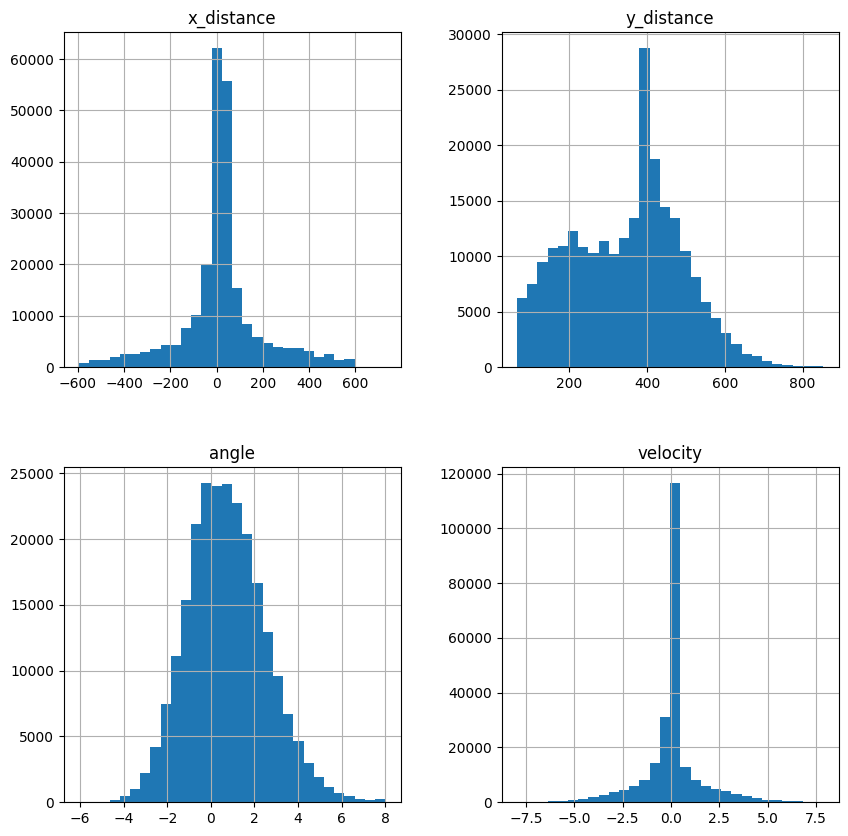

In [67]:
# get the histgram for the dataset
dataset.hist(bins=30,figsize=(10,10))
plt.show()

In [68]:
class Preprocessing:
    """
    A custom Preprocessing class for data normalization and standardization, including inverse scaling methods.
    This class supports Min-Max scaling and standard scaling, commonly used for preparing data before training.

    Methods
    -------
    minmax_scale(x : np.ndarray) -> np.ndarray
        Applies Min-Max scaling to the input data, transforming it to the range [0, 1].

    standard_scale(x : np.ndarray) -> np.ndarray
        Applies standard scaling to the input data, centering it to mean zero and unit variance.

    minmax_inverse_scale(x : np.ndarray) -> np.ndarray
        Reverts the Min-Max scaling, transforming the scaled data back to its original range.

    standard_inverse_scale(x : np.ndarray) -> np.ndarray
        Reverts the standard scaling, transforming the standardized data back to its original mean and variance.

    Attributes
    ----------
    min : np.ndarray
        Stores the minimum values of the features for Min-Max scaling, calculated during minmax_scale().

    max : np.ndarray
        Stores the maximum values of the features for Min-Max scaling, calculated during minmax_scale().

    mean : np.ndarray
        Stores the mean values of the features for standard scaling, calculated during standard_scale().

    std : np.ndarray
        Stores the standard deviation of the features for standard scaling, calculated during standard_scale().

    Notes
    -----
    This class provides essential methods for scaling and inverse scaling, which are important for maintaining data
    consistency when preprocessing data for machine learning models.
    """
    def __init__(self):
        # Initialize an empty class without setting attributes initially.
        pass

    def minmax_scale(self, x):
        """
        Scales the data to the range [0, 1] using Min-Max scaling.

        Args:
        x : np.ndarray
            Input data to be scaled.

        Returns
        -------
        np.ndarray
            Min-Max scaled data.
        """
        # Calculate the minimum and maximum values for each feature
        self.min = np.min(x, axis=0)
        self.max = np.max(x, axis=0)
        # Scale data to the [0, 1] range
        return (x - self.min) / (self.max - self.min)

    def standard_scale(self, x):
        """
        Scales the data to have zero mean and unit variance using standard scaling.

         Args:
        x : np.ndarray
            Input data to be standardized.

        Returns
        -------
        np.ndarray
            Standardized data.
        """
        # Calculate the mean and standard deviation for each feature
        self.mean = np.mean(x, axis=0)
        self.std = np.std(x, axis=0)
        # Scale data to have mean zero and standard deviation one
        return (x - self.mean) / self.std

    def minmax_inverse_scale(self, x):
        """
        Reverts the Min-Max scaling, transforming the scaled data back to its original range.

         Args:
        x : np.ndarray
            Scaled data to be reverted.

        Returns
        -------
        np.ndarray
            Data in its original range.
        """
        # Transform scaled data back to the original range
        return x * (self.max - self.min) + self.min

    def standard_inverse_scale(self, x):
        """
        Reverts the standard scaling, transforming the standardized data back to its original mean and variance.

         Args:
        x : np.ndarray
            Standardized data to be reverted.

        Returns
        -------
        np.ndarray
            Data in its original distribution with original mean and variance.
        """
        # Transform standardized data back to the original distribution
        return x * self.std + self.mean


In [74]:
# Get x and y
x = np.array(dataset.drop(["angle"	,"velocity"],axis=1).values)
y = np.array(dataset[["angle","velocity"]].values)

In [75]:
x.shape

(237534, 2)

In [76]:
# Standrize the dataset
x_normalizer = Preprocessing()
y_normalizer = Preprocessing()
x_norm = x_normalizer.minmax_scale(x)
y_norm = y_normalizer.minmax_scale(y)


In [77]:
# save the x and y normalizers
import pickle
with open('x_normalizer.pkl', 'wb') as f:
    pickle.dump(x_normalizer, f)

with open('y_normalizer.pkl', 'wb') as f:
    pickle.dump(y_normalizer, f)

In [78]:
def train_test_split(x, y, test_size):
    """
    Splits the dataset into training and testing sets based on the specified test size ratio.

    Args:
    x : np.ndarray
        Input features for the dataset.

    y : np.ndarray
        Target labels for the dataset.

    test_size : float
        Proportion of the dataset to be used as the test set (between 0 and 1).

    Returns
    -------
    tuple
        Four arrays: x_train, y_train, x_test, y_test.
    """
    # Generate an array of indices and shuffle it to randomize the dataset
    indices = np.arange(len(x))
    np.random.shuffle(indices)

    # Shuffle the dataset using the randomized indices
    x = x[indices]
    y = y[indices]

    # Determine the number of samples in the test set
    test_size = int(len(x) * test_size)

    # Split the dataset into training and testing sets
    x_train = x[:-test_size]
    y_train = y[:-test_size]
    x_test = x[-test_size:]
    y_test = y[-test_size:]

    return x_train, y_train, x_test, y_test


In [79]:
# Split the data into training and testing
# Here, we use 20% of the total dataset for testing
x_train, y_train, x_test, y_test = train_test_split(x_norm, y_norm, test_size=0.2)

# Further split the training set into training and validation sets
# Here, we use 10% of the training data as the validation set
x_train, y_train, x_val, y_val = train_test_split(x_train, y_train, test_size=0.1)


## Build the Data Pipeline

In [80]:
class Pipeline:
    """
    A custom Pipeline class for managing data batching and shuffling, supporting both training and inference modes.
    This class enables efficient data handling for model training by organizing data into batches and shuffling when needed.

    Parameters
    ----------
    x : np.ndarray
        Input features for the dataset.

    y : np.ndarray
        Target labels for the dataset.

    batch_size : int
        Number of samples per batch.

    training : bool, optional, default=False
        Whether to enable shuffling for training mode.

    Methods
    -------
    batch(x : np.ndarray, y : np.ndarray, batch_size : int) -> list of tuples
        Splits the dataset into batches based on the specified batch size, returning a list of (input, target) pairs.

    shuffle(x : np.ndarray, y : np.ndarray) -> tuple
        Shuffles the dataset, ensuring inputs and targets are aligned, used only in training mode.

    __call__() -> list of tuples
        Generates the dataset in batches, shuffling if training is enabled.

    Returns
    -------
    dataset : list of tuples
        A list containing tuples of batched (input, target) pairs.

    Notes
    -----
    This class provides an efficient way to handle data during model training, supporting shuffling for training and batch generation.
    """
    def __init__(self, x, y, batch_size, training=False):
        """
        Initializes the Pipeline class with dataset features, targets, batch size, and training flag.

         Args:
        x : np.ndarray
            Input features for the dataset.

        y : np.ndarray
            Target labels for the dataset.

        batch_size : int
            Number of samples per batch.

        training : bool, optional
            Whether to enable shuffling, typically set to True for training mode.
        """
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.training = training

    def batch(self, x, y, batch_size):
        """
        Splits the dataset into batches.

         Args:
        x : np.ndarray
            Input features for the dataset.

        y : np.ndarray
            Target labels for the dataset.

        batch_size : int
            Number of samples per batch.

        Returns
        -------
        list of tuples
            A list containing tuples of (input, target) pairs for each batch.
        """
        # Create batches based on the specified batch size
        batches = []
        for i in range(0, len(x), batch_size):
            batches.append((x[i:i + batch_size], y[i:i + batch_size]))
        return batches

    def shuffle(self, x, y):
        """
        Shuffles the dataset while keeping inputs and targets aligned.

         Args:
        x : np.ndarray
            Input features for the dataset.

        y : np.ndarray
            Target labels for the dataset.

        Returns
        -------
        tuple
            Shuffled input features and targets.
        """
        # Generate random indices and shuffle both x and y accordingly
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        return x[indices], y[indices]

    def __call__(self):
        """
        Generates the dataset in batches. If training is enabled, the dataset is shuffled.

        Returns
        -------
        list of tuples
            A list containing tuples of batched (input, target) pairs.
        """
        # Shuffle data if in training mode
        if self.training:
            self.x, self.y = self.shuffle(self.x, self.y)

        # Create and return batches of the dataset
        dataset = self.batch(self.x, self.y, self.batch_size)
        return dataset


In [81]:
def create_pipeline(x, y, batch_size, training=False):
    """
    Creates a Pipeline instance for batching and shuffling data, enabling flexible data handling for different datasets.

     Args:
    x : np.ndarray
        Input features for the dataset.

    y : np.ndarray
        Target labels for the dataset.

    batch_size : int
        Number of samples per batch.

    training : bool, optional
        If True, enables shuffling of the dataset for training purposes. Default is False.

    Returns
    -------
    Pipeline
        An instance of the Pipeline class for batching and optionally shuffling the data.
    """
    # Initialize a Pipeline with the given data, batch size, and training flag
    pipeline = Pipeline(x, y, batch_size, training)
    return pipeline

# Create a Pipeline for the training dataset with shuffling enabled
training_dataset = create_pipeline(x_train, y_train,
                                   batch_size= 64, training=True)

# Create a Pipeline for the evaluation dataset without shuffling
evalution_dataset = create_pipeline(x_val, y_val, batch_size=64)

# Create a Pipeline for the testing dataset without shuffling
testing_dataset = create_pipeline(x_test, y_test, batch_size=64)


# Test the Pipeline

In [82]:
for x,y in training_dataset():
    print(x.shape)
    print(x)
    print(y.shape)
    print(y)
    break



(64, 2)
[[0.44863605 0.21785562]
 [0.45278026 0.67788093]
 [0.4768443  0.33560721]
 [0.46465533 0.19515989]
 [0.06803638 0.56281893]
 [0.60662889 0.38748441]
 [0.37979603 0.34844375]
 [0.75728802 0.43910299]
 [0.28457855 0.43027659]
 [0.45772534 0.21693636]
 [0.47445089 0.32523303]
 [0.50722579 0.41007514]
 [0.44822417 0.61278841]
 [0.46774757 0.10712638]
 [0.46120046 0.9430947 ]
 [0.50590594 0.23162997]
 [0.48015075 0.40164299]
 [0.45332886 0.23132976]
 [0.47415049 0.02573729]
 [0.46020503 0.49666905]
 [0.45995869 0.1473825 ]
 [0.39090965 0.3391298 ]
 [0.47541083 0.31323394]
 [0.44257009 0.22828741]
 [0.52619576 0.41298474]
 [0.50967034 0.2198872 ]
 [0.54170423 0.67982011]
 [0.43755714 0.31608053]
 [0.48493598 0.15455543]
 [0.02538076 0.40888108]
 [0.47940715 0.04955051]
 [0.63362247 0.41763989]
 [0.38998834 0.49089196]
 [0.5498016  0.68397912]
 [0.46069535 0.21479802]
 [0.54331774 0.58497764]
 [0.46449698 0.08393682]
 [0.32275715 0.69819353]
 [0.37933073 0.31561453]
 [0.07941518 0.50

In [84]:
print(len(training_dataset()))
print(len(evalution_dataset()))
print(len(testing_dataset()))

2673
297
743


## Test the Model with Dataset

In [ ]:
# build model with 2 inputs features and two hidden layers of uniber of units is 16,32
# with hidden_layers_activation="leaky_relu",
# 2 output units layer with linear output_layer_activation
model = Model(input_shape=2,
              layers_units=[16,32],
              hidden_layers_activation="leaky_relu",
              output_layer_units=2,
              output_layer_activation=None)
# initialize the loss to rmse
loss = Loss('rmse')
# build the modle
model.model_generator()
# initial the Gradient
gradient = Gradient()
# get the r2_score
r2_score = Evaluation().r2_score
# Initial the optimizer and link it with the model
sdg = SGDMomentum(model)
for j in range(10):
    for x, y in training_dataset():

        # Make prediction with make sure the model in the training mode
        pred = model(x,training=True)
        # Get the error and the error gradient
        error,error_grad = loss(y,pred)
        print(error)

        # Get the for the model gradient to the loss
        gradient(model.model_cache,error_grad)
        # Update the model trainabel parameters using the gradients
        sdg.update_params(gradient.get_gradients())


# Build the Traniner

In [98]:
class Trainer:
    """
    A custom Trainer class for training and evaluating a neural network model. This class supports model building,
    backpropagation, parameter updating using SGD with momentum, and performance tracking over epochs.

    Attributes
    ----------
    model : Model
        The neural network model being trained.

    loss : Loss
        The loss function used to compute the error during training.

    gradient : Gradient
        Computes the gradients of the loss with respect to model parameters.

    evaluation : Evaluation
        Provides evaluation metrics for tracking model performance.

    sdg : SGDMomentum
        Optimizer implementing SGD with momentum for parameter updates.

    history : dict
        Stores the training and evaluation loss and R2 score across epochs for performance tracking.

    Methods
    -------
    fit(training_dataset, evalution_dataset, epochs=10, path_for_best_model=None)
        Trains the model over a specified number of epochs, evaluates on validation data, and saves the best model.

    Notes
    -----
    This class provides a flexible approach to training and evaluating a neural network model,
    with detailed tracking of loss and R2 score metrics. It allows saving the best model based on evaluation loss.
    """
    def __init__(self, features_size: int, layers_units: list,
                 hidden_layers_activation="leaky_relu",
                output_layer_units=None,
                output_layer_activation=None,
                 loss=None, learning_rate=0.01, momentum=0.9):
        """
        Initializes the Trainer class with model parameters, builds the model, and initializes components
        like loss, gradient, evaluation, and optimizer.

        Arge
        ----------
        features_size : int
            The size of the input features.

        layers_units : list
            A list defining the units in each hidden layer.


         hidden_layers_activation : str, optional
            The activation function to be used in hidden layers, default is "leaky_relu".

        output_layer_units : int, optional
            The number of units in the output layer, default is None.

        output_layer_activation : str, optional
            The activation function to be used in the output layer, default is None.


        loss : Loss
            The loss function to be used in training,  default is None.

        learning_rate : float, optional
            The learning rate for the optimizer, default is 0.01.

        momentum : float, optional
            The momentum factor for the optimizer, default is 0.9.
        """
        super().__init__()
        self.build_model(features_size, layers_units,
                         hidden_layers_activation,
                         output_layer_units,
                         output_layer_activation,
                         loss,
                         learning_rate, momentum)


    def build_model(self, features_size: int, layers_units: list,
                    hidden_layers_activation="leaky_relu",
                    output_layer_units=None,
                    output_layer_activation=None,
                    loss=None, learning_rate=0.01, momentum=0.9):
        """
        Builds the neural network model, initializes the loss function, and sets up components for
        gradient computation, evaluation, and optimization.

        Arge
        ----------
        features_size : int
            The size of the input features.

        layers_units : list
            A list defining the units in each hidden layer.

        hidden_layers_activation : str, optional
            The activation function to be used in hidden layers, default is "leaky_relu".

        output_layer_units : int, optional
            The number of units in the output layer, default is None.

        output_layer_activation : str, optional
            The activation function to be used in the output layer, default is None.

        loss : Loss
            The loss function to be used in training.

        learning_rate : float, optional
            The learning rate for the optimizer, default is 0.01.

        momentum : float, optional
            The momentum factor for the optimizer, default is 0.9.
        """
        # Initialize model with given architecture
        self.model = Model(features_size, layers_units,
                           hidden_layers_activation,
                           output_layer_units,
                           output_layer_activation)
        # Initialize loss function
        self.loss = Loss(loss)
        # Generate model layers and initialize parameters
        self.model.model_generator()

        # Initialize components for gradient calculation, evaluation metrics, and optimizer
        self.gradient = Gradient()
        self.evaluation = Evaluation()
        self.sdg = SGDMomentum(self.model, learning_rate=learning_rate, momentum=momentum)

        # Initialize history to track performance across epochs
        self.history = {
            "training": {
                "loss": [],
                "r2_score": []
            },
            "evalution": {
                "loss": [],
                "r2_score": []
            },
            "testing": {
                "loss": [],
                "r2_score": []
            }
        }

    def fit(self, training_dataset, evalution_dataset, epochs=10, path_for_best_model=None,
            early_stopping=False,patience=5):
        """
        Trains the model for a given number of epochs and evaluates its performance on a validation dataset.
        Tracks performance metrics, saves the best model based on evaluation loss and optionally applies early stopping.

        Arge
        ----------
        training_dataset : callable
            A function or generator yielding batches of training data (x, y).

        evalution_dataset : callable
            A function or generator yielding batches of evaluation data (x, y).

        epochs : int, optional
            The number of epochs for training, default is 10.

        path_for_best_model : str, optional
            Path to save the best-performing model based on validation loss.

        early_stopping : bool, optional
            Whether to apply early stopping based on validation loss, default is False.
        patience : int, optional
            Number of epochs to wait for improvement before early stopping, default is 5.
        """
        # Initialize variable to track the best evaluation loss for model saving
        self.old_loss = 100000

        self.patience = patience
        self.counter = 0

        # Main training loop over specified epochs
        for epoch in range(epochs):
            # Temporary storage for metrics in the current epoch
            record = {
                "training": {
                    "loss": [],
                    "r2_score": []
                },
                "evalution": {
                    "loss": [],
                    "r2_score": []
                },
            }
            print(f"Epoch {epoch+1}/{epochs}")



            # Training loop: iterate over training batches
            for x, y in training_dataset():
                # Forward pass
                pred = self.model(x, training=True)
                error, error_grad = self.loss(y, pred)
                r2_score = self.evaluation.r2_score(y, pred)

                # Backpropagation and parameter update
                self.gradient(self.model.model_cache, error_grad)
                self.sdg.update_params(self.gradient.get_gradients())

                # Record training loss and R2 score
                record["training"]["loss"].append(error)
                record["training"]["r2_score"].append(r2_score)

            # Evaluation loop: iterate over evaluation batches
            for x, y in evalution_dataset():
                # Forward pass (no backpropagation)
                pred = self.model(x, training=False)
                error, _ = self.loss(y, pred)
                r2_score = self.evaluation.r2_score(y, pred)

                # Record evaluation loss and R2 score
                record["evalution"]["loss"].append(error)
                record["evalution"]["r2_score"].append(r2_score)

            # Convert recorded lists to numpy arrays for easier manipulation
            for key in record.keys():
                for sub_key in record[key].keys():
                    record[key][sub_key] = np.array(record[key][sub_key])

            # Store the mean loss and R2 score in the history for tracking
            self.history["training"]["loss"].append(np.mean(record["training"]["loss"]))
            self.history["training"]["r2_score"].append(np.mean(record["training"]["r2_score"]))
            self.history["evalution"]["loss"].append(np.mean(record["evalution"]["loss"]))
            self.history["evalution"]["r2_score"].append(np.mean(record["evalution"]["r2_score"]))

            # Print a summary for the current epoch
            print(f"""

            Model Summary:
            Epoch: {epoch+1}/{epochs}
            Training Loss: {self.history["training"]["loss"][-1]}
            Training R2 Score: {self.history["training"]["r2_score"][-1]}
            Evalution Loss: {self.history["evalution"]["loss"][-1]}
            Evalution R2 Score: {self.history["evalution"]["r2_score"][-1]}

            """)
            print("#" * 50)
            break_training = self.save_best_model_with_early_stopping(epoch,
                                                                      path_for_best_model,
                                                                      early_stopping)
            if break_training:
                break



        # plot the history of the training
        df = pd.DataFrame({
            "training_loss": self.history["training"]["loss"],
            #"training_r2_score": self.history["training"]["r2_score"],
            "evalution_loss": self.history["evalution"]["loss"],
            #"evalution_r2_score": self.history["evalution"]["r2_score"]
        })


        # get the index where is evalution_loss equle to the old loss
        step = df.index[df["evalution_loss"] == self.old_loss].tolist()[0]



        # Show the data
        sns.lineplot(data=df,)
        plt.legend()
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        # use the step value to make a mark on the plot
        plt.axvline(x=step, color='r', linestyle='--')
        plt.show()






    def save_best_model_with_early_stopping(self, epoch, path_for_best_model, early_stopping):
        """
        Saves the best-performing model based on validation loss and applies early stopping if enabled.

        Args
        ----------
        epoch : int
            Current epoch number.

        path_for_best_model : str
            Path to save the best-performing model.

        early_stopping : bool
            Whether to apply early stopping based on validation loss.

        Returns
        -------
        bool
            Returns True if early stopping criterion is met, False otherwise.
        """

        # Check if the current evaluation loss is the lowest and save the model if so
        if (self.history["evalution"]["loss"][-1] < self.old_loss) and \
        (self.history["evalution"]["loss"][-1] < self.history["training"]["loss"][-1]) and \
        path_for_best_model:
            # Reset counter for early stopping when a new best model is found
            self.counter = 0

            print(f"Best model found at epoch {epoch+1} with loss {self.history['evalution']['loss'][-1]}")

            # Update old_loss to the current best evaluation loss
            self.old_loss = self.history["evalution"]["loss"][-1]

            # Save the current model as the best model
            with open(path_for_best_model, "wb") as f:
                pickle.dump(self.model, f)


        # Check for early stopping if enabled
        if early_stopping:
            # Increment counter if the current loss is not improving
            if self.history["evalution"]["loss"][-1] > self.old_loss:
                self.counter += 1

                # If counter reaches the patience threshold, stop training
                if self.counter >= self.patience:
                    print(f"Early stopping at epoch {epoch+1} with loss {self.history['evalution']['loss'][-1]}")
                    print(f"Early stopping at epoch {epoch+1} with loss {self.history['training']['loss'][-1]}")
                    return True

        # Continue training if early stopping is not triggered
        return False







    def model_testing(self,testing_dataset, path_for_best_model:str):
        """
        Tests the model on a testing dataset using the best saved model.

        Args
        ----------
        testing_dataset : callable
            A function or generator yielding batches of testing data (x, y).

        path_for_best_model : str
            Path to load the best-performing model for testing.
        """

        with open(path_for_best_model, "rb") as f:
            best_model = pickle.load(f)

        # make prediction
        pred = np.array([])
        y_true = np.array([])
        x = np.array([])
        for x,y in testing_dataset():
            predictions = best_model(x,training=False)

            # append the result of predicion and y to the pred and y_true
            pred = np.append(pred,predictions)
            y_true = np.append(y_true,y)

        # reshape y_true and pred
        pred = pred.reshape(-1,y.shape[-1])
        y_true = y_true.reshape(-1,y.shape[-1])

        print(pred.shape)
        print(y_true.shape)


        # get the mse, rmse and r2
        mse = self.evaluation.mse(y_true,pred)
        rmse = self.evaluation.rmse(y_true,pred)
        r2 = self.evaluation.r2_score(y_true,pred)

        print(f"MSE: {mse}")
        print(f"RMSE: {rmse}")
        print(f"R2: {r2}")

        # scatter plot for the true with pred sub plot for the x_velocity and y_velocity
        # scater the pred and true make the ture blue and the pred is red
        plt.scatter(y_true[:, 0], y_true[:, 1], )
        plt.scatter(pred[:, 0], pred[:, 1])
        plt.xlabel('y1')
        plt.ylabel('y2')
        plt.legend()







        return mse,rmse,r2








# Testing the Trainer

In [87]:
trainer = Trainer(
    features_size=2,
    layers_units=[8],

    hidden_layers_activation="leaky_relu",
    output_layer_units=2,
    output_layer_activation=None,

    loss="rmse",
    learning_rate=0.01,
    momentum=0.9)
trainer.model.model[-1].weight

array([[-0.21730289,  0.78066008],
       [ 0.40182529,  0.17088151],
       [-0.59579319, -0.59583497],
       [-0.76542164,  0.63423569],
       [ 0.17513634,  0.36039228],
       [-0.83037201,  0.81390774],
       [ 0.57580754, -0.49824328],
       [-0.55109532, -0.54835947]])

Epoch 1/100


            Model Summary:
            Epoch: 1/100
            Training Loss: 0.10709469302665714
            Training R2 Score: -0.4574121309945535
            Evalution Loss: 0.09753145280412141
            Evalution R2 Score: 0.25042518531878954

            
##################################################
Best model found at epoch 1 with loss 0.09753145280412141
Epoch 2/100


            Model Summary:
            Epoch: 2/100
            Training Loss: 0.09744693312711697
            Training R2 Score: 0.2522428210837058
            Evalution Loss: 0.0960715372386155
            Evalution R2 Score: 0.2732057789953242

            
##################################################
Best model found at epoch 2 with loss 0.0960715372386155
Epoch 3/100


            Model Summary:
            Epoch: 3/100
            Training Loss: 0.09666251446483412
            Training R2 Score: 0.26339835771746734
            Evalution Loss: 0.09767140550557918
            Evalut

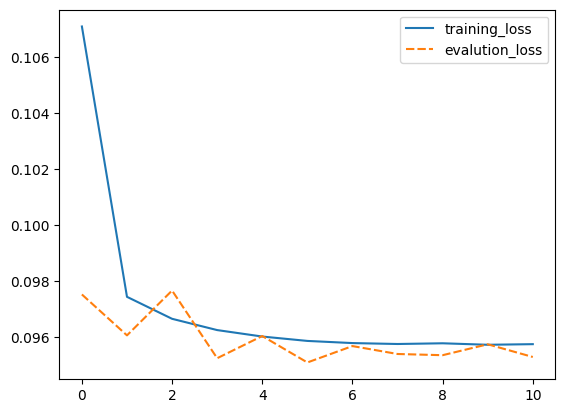

In [ ]:

trainer.fit(training_dataset,evalution_dataset,
            epochs=100,path_for_best_model="best_model.pkl",early_stopping=True,
            patience=5)

(47506, 2)
(47506, 2)
MSE: 0.008753474732036746
RMSE: 0.09356000604979002
R2: 0.32699970951219126


(0.008753474732036746, 0.09356000604979002, 0.32699970951219126)

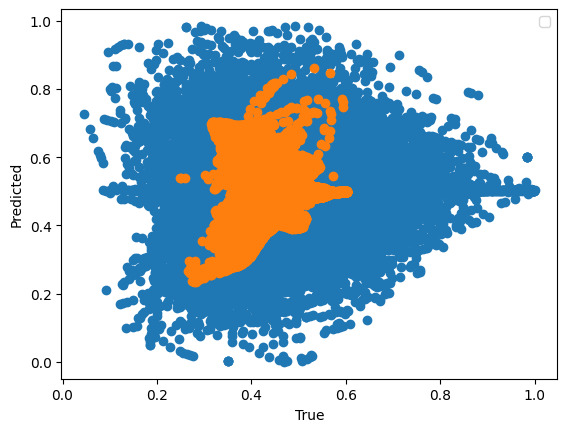

In [ ]:
trainer.model_testing(testing_dataset,"best_model.pkl")

In [ ]:
trainer.model.model_cache

{}

In [ ]:
class HyperparameterTuner(Evaluation, Trainer):
    """
    A class for tuning hyperparameters of a neural network model using Optuna. This class
    inherits from both Evaluation and Trainer classes, enabling model building, training, and
    evaluation while optimizing hyperparameters like learning rate, momentum, and layer structure.

    Attributes
    ----------
    n_trials : int
        Number of trials for the hyperparameter optimization process.

    training_dataset : callable
        Dataset for training, usually a function or generator yielding training batches.

    evalution_dataset : callable
        Dataset for validation, usually a function or generator yielding validation batches.

    testing_dataset : callable
        Dataset for testing, usually a function or generator yielding testing batches.

    number_layers : int
        Maximum number of layers to consider during tuning.

    number_units : int
        Maximum number of units per layer to consider during tuning.

    Methods
    -------
    objective(trial)
        Defines the objective function for Optuna to minimize, including model building and training.

    __call__()
        Runs the hyperparameter optimization process and returns the best hyperparameters and value.
    """

    def __init__(self, n_trials, training_dataset, evalution_dataset, testing_dataset,
                 number_layers: int, number_units: int):
        """
        Initializes the HyperparameterTuner with datasets, the number of trials, and model parameters.

        Args
        ----------
        n_trials : int
            The number of trials to run for hyperparameter optimization.

        training_dataset : callable
            The training data generator or function.

        evalution_dataset : callable
            The validation data generator or function.

        testing_dataset : callable
            The testing data generator or function.

        number_layers : int
            The maximum number of layers to consider.

        number_units : int
            The maximum number of units in each layer.
        """
        self.n_trials = n_trials
        self.training_dataset = training_dataset
        self.evalution_dataset = evalution_dataset
        self.testing_dataset = testing_dataset
        self.number_layers = number_layers
        self.number_units = number_units

    def objective(self, trial):
        """
        Defines the objective function for Optuna, specifying the model architecture,
        hyperparameters, and evaluation metrics to minimize.

        Args
        ----------
        trial : optuna.Trial
            An Optuna trial object to sample hyperparameters.

        Returns
        -------
        float
            The RMSE of the model on the testing dataset, which Optuna will aim to minimize.
        """
        # Sample hyperparameters
        n_layers = trial.suggest_int('n_layers', 1, self.number_layers)
        layers_units = [trial.suggest_int(f'layer_{i}_units', 4, self.number_units) for i in range(n_layers)]
        lr = trial.suggest_loguniform('lr', 1e-3, 1e-1)
        momentum = trial.suggest_uniform('momentum', 0.0, 0.99)

        # Print sampled hyperparameters
        print("#" * 100)
        print(f"n_layers: {n_layers}")
        print(f"layers_units: {layers_units}")
        print(f"lr: {lr}")
        print(f"momentum: {momentum}")

        # Build and train the model
        self.build_model(features_size=2, layers_units=layers_units,
                         hidden_layers_activation="leaky_relu",
                         output_layer_units=2,
                         output_layer_activation=None,
                         loss="rmse", learning_rate=lr, momentum=momentum)
        self.fit(self.training_dataset, self.evalution_dataset, epochs=10,
                 path_for_best_model="best_model.pkl")

        # Test the model and return RMSE
        mse, rmse, r2 = self.model_testing(self.testing_dataset, "best_model.pkl")
        return rmse

    def __call__(self):
        """
        Runs the Optuna optimization process and returns the best hyperparameters and metric.

        Returns
        -------
        tuple
            Best hyperparameters and their corresponding RMSE score.
        """
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, n_trials=self.n_trials)
        print(f"Best hyperparameters: {study.best_params}")
        print(f"Best metrics: {study.best_value}")
        return study.best_params, study.best_value


# Get the best Parameter for the model using hyperparameter tuner

In [ ]:
# Hyperparameter tuner for just one hidden layer
hyperparameter_tuner = HyperparameterTuner(
    n_trials=100,
    training_dataset=training_dataset,
    evalution_dataset=evalution_dataset,
    testing_dataset=testing_dataset,
    number_layers = 4,
    number_units= 256)
hyperparameter_tuner()

# Best Model Parameters for one Hidden Layer

In [112]:
trainer = Trainer(
    features_size=2,
    layers_units=[32],
    hidden_layers_activation="leaky_relu",
    output_layer_units=2,
    output_layer_activation=None,
    loss="rmse",
    learning_rate=0.016999196585549076,
    momentum= 0.7300579819978946,)
trainer.model.model[0].weight

array([[-0.43460578,  1.56132016,  0.80365059,  0.34176301, -1.19158638,
        -1.19166994, -1.53084327,  1.26847138,  0.35027268,  0.72078455,
        -1.66074403,  1.62781548,  1.15161509, -0.99648655, -1.10219064,
        -1.09671895, -0.67812476,  0.08575879, -0.23574937, -0.72320347,
         0.38746979, -1.2488299 , -0.72003206, -0.46293615, -0.15217804,
         0.98787851, -1.04036054,  0.04930954,  0.32013346, -1.57114186,
         0.3725463 , -1.14133792],
       [-1.50670548,  1.55498511,  1.61299668,  1.06831975, -0.67683776,
        -1.39370468,  0.63820192, -0.20731784, -1.30929796, -0.01670767,
        -1.61292548,  1.41792747, -0.83561066,  0.56299371, -0.65225197,
         0.06951766,  0.16180915, -1.09169619,  1.62668887,  0.95308806,
         1.52246899,  1.36772206,  0.33913547,  1.46141522, -1.42550379,
        -1.05314626, -1.57537888, -0.60507348, -0.38563318, -0.79207019,
         1.13878014, -0.49622103]])

Epoch 1/100


            Model Summary:
            Epoch: 1/100
            Training Loss: 0.1030047907531014
            Training R2 Score: 0.041397771207037345
            Evalution Loss: 0.09974124934907058
            Evalution R2 Score: 0.21642934423351054

            
##################################################
Best model found at epoch 1 with loss 0.09974124934907058
Epoch 2/100


            Model Summary:
            Epoch: 2/100
            Training Loss: 0.09830452321166981
            Training R2 Score: 0.23909055120310255
            Evalution Loss: 0.09828802419218727
            Evalution R2 Score: 0.23876026221125995

            
##################################################
Best model found at epoch 2 with loss 0.09828802419218727
Epoch 3/100


            Model Summary:
            Epoch: 3/100
            Training Loss: 0.09748777741381648
            Training R2 Score: 0.2516484453733193
            Evalution Loss: 0.09854987687676293
            Eva

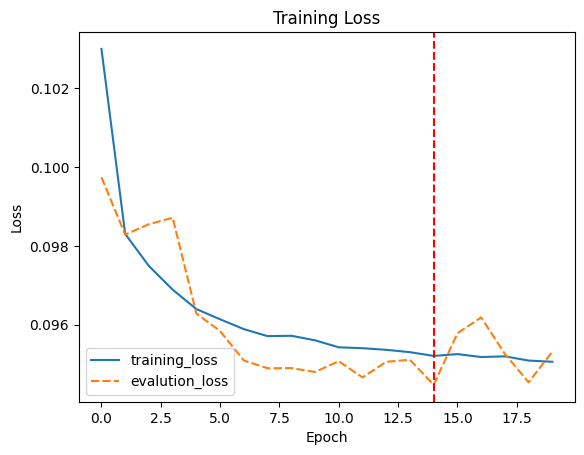

In [113]:

trainer.fit(training_dataset,evalution_dataset,
            epochs=100,path_for_best_model="best_model.pkl",
            early_stopping=True,patience=5)

(47506, 2)
(47506, 2)
MSE: 0.00897809635135004
RMSE: 0.09475281711564064
R2: 0.3081664812274859


(0.00897809635135004, 0.09475281711564064, 0.3081664812274859)

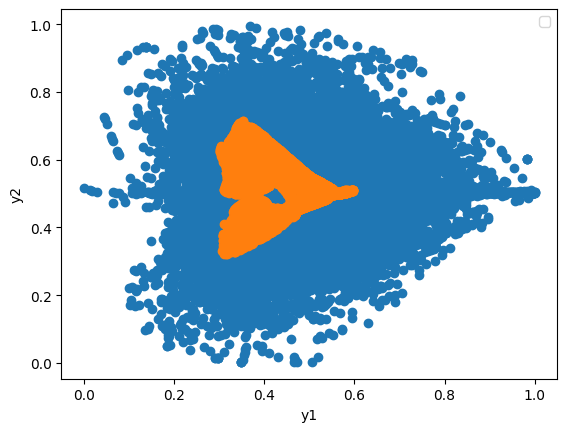

In [114]:
trainer.model_testing(testing_dataset,"best_model.pkl")

# Best Model Parameters for one Multi Hidden Layers

In [ ]:
# Hyperparameter tuner for just one hidden layer
hyperparameter_tuner = HyperparameterTuner(
    n_trials=100,
    training_dataset=training_dataset,
    evalution_dataset=evalution_dataset,
    testing_dataset=testing_dataset,
    number_layers = 4,
    number_units= 256)
hyperparameter_tuner()

In [ ]:
"""MSE: 0.008756094785516413
RMSE: 0.0935740069972234
R2: 0.32372161547871126
Best hyperparameters: {'n_layers': 4, 'layer_0_units': 47, 'layer_1_units': 73, 'layer_2_units': 193, 'layer_3_units': 220, 'lr': 0.004815705779303907, 'momentum': 0.8030075558694258}
Best metrics: 0.09327171812374323
({'n_layers': 4,
  'layer_0_units': 47,
  'layer_1_units': 73,
  'layer_2_units': 193,
  'layer_3_units': 220,
  'lr': 0.004815705779303907,
  'momentum': 0.8030075558694258},
 0.09327171812374323)"""

"MSE: 0.008756094785516413\nRMSE: 0.0935740069972234\nR2: 0.32372161547871126\nBest hyperparameters: {'n_layers': 4, 'layer_0_units': 47, 'layer_1_units': 73, 'layer_2_units': 193, 'layer_3_units': 220, 'lr': 0.004815705779303907, 'momentum': 0.8030075558694258}\nBest metrics: 0.09327171812374323\n({'n_layers': 4,\n  'layer_0_units': 47,\n  'layer_1_units': 73,\n  'layer_2_units': 193,\n  'layer_3_units': 220,\n  'lr': 0.004815705779303907,\n  'momentum': 0.8030075558694258},\n 0.09327171812374323)"

In [104]:
trainer = Trainer(
    features_size=2,
    layers_units=[47,73,193,220],
    hidden_layers_activation="leaky_relu",
    output_layer_units=2,
    output_layer_activation=None,
    loss="rmse",
    learning_rate=0.004815705779303907,
    momentum= 0.8030075558694258)
trainer.model.model[0].weight

array([[-0.43460578,  1.56132016,  0.80365059,  0.34176301, -1.19158638,
        -1.19166994, -1.53084327,  1.26847138,  0.35027268,  0.72078455,
        -1.66074403,  1.62781548,  1.15161509, -0.99648655, -1.10219064,
        -1.09671895, -0.67812476,  0.08575879, -0.23574937, -0.72320347,
         0.38746979, -1.2488299 , -0.72003206, -0.46293615, -0.15217804,
         0.98787851, -1.04036054,  0.04930954,  0.32013346, -1.57114186,
         0.3725463 , -1.14133792, -1.50670548,  1.55498511,  1.61299668,
         1.06831975, -0.67683776, -1.39370468,  0.63820192, -0.20731784,
        -1.30929796, -0.01670767, -1.61292548,  1.41792747, -0.83561066,
         0.56299371, -0.65225197],
       [ 0.06951766,  0.16180915, -1.09169619,  1.62668887,  0.95308806,
         1.52246899,  1.36772206,  0.33913547,  1.46141522, -1.42550379,
        -1.05314626, -1.57537888, -0.60507348, -0.38563318, -0.79207019,
         1.13878014, -0.49622103, -0.75886512,  0.14790357, -1.24387497,
         1.04684

Epoch 1/100


            Model Summary:
            Epoch: 1/100
            Training Loss: 0.0998591941680385
            Training R2 Score: 0.18252816743764436
            Evalution Loss: 0.09604973061284516
            Evalution R2 Score: 0.27348193147421884

            
##################################################
Best model found at epoch 1 with loss 0.09604973061284516
Epoch 2/100


            Model Summary:
            Epoch: 2/100
            Training Loss: 0.0956741925603909
            Training R2 Score: 0.27859224009758937
            Evalution Loss: 0.09685381941078133
            Evalution R2 Score: 0.2599996722458441

            
##################################################
Epoch 3/100


            Model Summary:
            Epoch: 3/100
            Training Loss: 0.09506640873578648
            Training R2 Score: 0.28771266824116304
            Evalution Loss: 0.09530461872454786
            Evalution R2 Score: 0.28440892637407317

            
#########

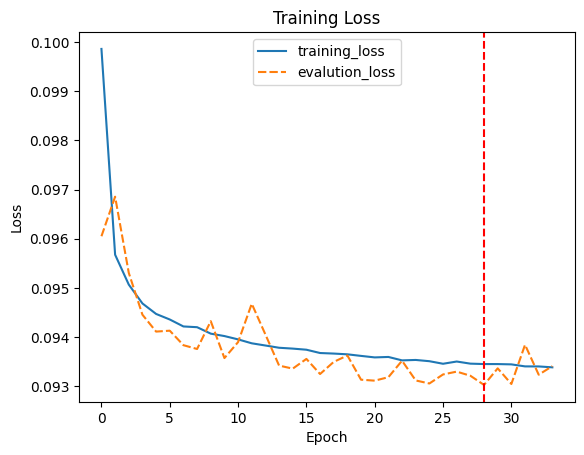

In [105]:

trainer.fit(training_dataset,evalution_dataset,
            epochs=100,path_for_best_model="best_model.pkl",
            early_stopping=True,patience=5)

(47506, 2)
(47506, 2)
MSE: 0.008710292671794217
RMSE: 0.09332894873400331
R2: 0.32880287837858935


(0.008710292671794217, 0.09332894873400331, 0.32880287837858935)

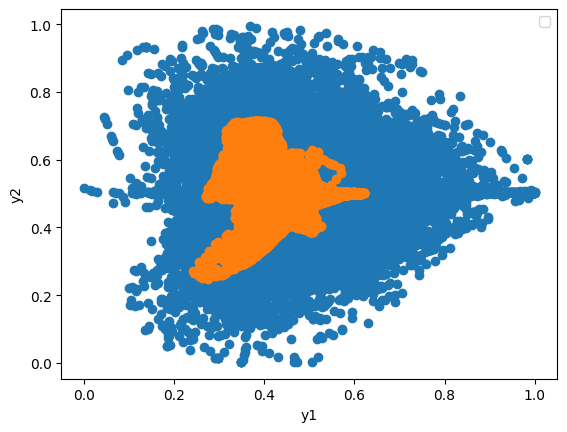

In [111]:
trainer.model_testing(testing_dataset,"best_model.pkl")